In [47]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup as bs
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from glob import glob

pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.options.display.float_format = '{:.2f}'.format

In [2]:
def get_num_episodes(chromedriver_path, platform = 'naver', lang = 'kr', titleId = 747269):
    """
    웹툰의 에피소드 개수를 구하는 함수
    """    
    if lang == 'kr':
        print('titleId가 ', titleId, "인 웹툰의 episode 개수를 구합니다.")
    elif lang == 'en':
        print("Get the number of episodes of titleId, ", titleId)
        
    # chrome driver setting    
    service = Service(executable_path=chromedriver_path)
    
    TIMEOUT = 1 
    driver = webdriver.Chrome(service=service)
    
    if platform == 'naver' and lang == 'kr':
        base_url = 'https://comic.naver.com/webtoon/list?' + 'titleId=' + str(titleId)
    elif platform == 'naver' and lang == 'en':    
        base_url = 'https://www.webtoons.com/en/action/omniscient-reader/list?' + 'title_no=' + str(titleId)
        
    print(base_url)
    driver.get(base_url)
    driver.implicitly_wait(TIMEOUT)   
       
    # Get the total number of pages
    if lang == 'kr':
        pages = driver.find_element(by=By.CSS_SELECTOR, value="#content > table > tbody > tr:nth-child(2) > td.title > a")
        num_episodes = int(pages.text.split('.')[0]) + 1
        print("num_episodes:", num_episodes)
    elif lang == 'en':  
        element = driver.find_element(by=By.CSS_SELECTOR, value="li._episodeItem")
        num_episodes = int(element.get_attribute("data-episode-no"))
        print("num_episodes:", num_episodes)
        
    driver.quit()
    return num_episodes

In [3]:
def get_comments(driver, df, lang = 'kr', titleId = 747269, episode_no = 1):
    """
    에피소드의 댓글을 수집하는 함수
    """        
    
    if lang == 'kr':
        base_url = 'https://comic.naver.com/webtoon/detail?'
        episode_url = base_url + 'titleId=' + str(titleId) + '&no='+str(episode_no)
    elif lang == 'en':
        # https://www.webtoons.com/en/action/omniscient-reader/episode-118/viewer?title_no=2154&episode_no=119
        base_url = 'https://www.webtoons.com/en/action/omniscient-reader/episode-'
        episode_url = base_url + str(episode_no -1) + '/viewer?title_no=' + str(titleId) + '&episode_no='+str(episode_no)        
        
    print(episode_url)
    driver.get(episode_url)
    driver.implicitly_wait(1)
    
    if lang == 'kr':
        # 댓글창에 해당하는 프레임 선택
        driver.switch_to.frame('commentIframe')

        # 수집 편의를 위한 클린봇 댓글 필터링 기능 해제
        # (클린봇이 부적절한 표현을 감지한 댓글입니다.) 제거
        driver.find_element(By.CLASS_NAME,'u_cbox_cleanbot_setbutton').click()
        time.sleep(0.2)
        driver.find_element(By.CLASS_NAME,'u_cbox_layer_cleanbot2_checkbox').click()
        time.sleep(0.2)
        driver.find_element(By.CLASS_NAME,'u_cbox_layer_cleanbot2_extrabtn').click()
        time.sleep(0.2)

        # 전체 댓글 클릭
        driver.find_element(By.CSS_SELECTOR,'#cbox_module > div > div.u_cbox_view_comment > a').click()
        time.sleep(0.5)        
    elif lang == 'en':
        # No iframe
        # No Cleanbot filtering setting
        # No need to click "전체 댓글"        
        pass 
    
    # Move to the last page and Get the total number of pages
    driver.find_element(By.CSS_SELECTOR,'#cbox_module > div > div.u_cbox_paginate > div > a.u_cbox_next.u_cbox_next_end').click()
    time.sleep(1)
    
    u_cbox_num_page = driver.find_element(By.CSS_SELECTOR,'#cbox_module > div > div.u_cbox_paginate > div > strong > span.u_cbox_num_page')
    time.sleep(1)
    num_pages = u_cbox_num_page.text
    print("num_pages:",num_pages)
  
    # Move to the first page
    driver.find_element(By.CSS_SELECTOR,'#cbox_module > div > div.u_cbox_paginate > div > a.u_cbox_pre.u_cbox_pre_end').click()
    time.sleep(0.5)

    for page in range(int(num_pages)):
        if lang == 'kr':        
            # switch to the recent tab
            driver.switch_to.window(driver.window_handles[-1]) 
            driver.switch_to.frame("commentIframe")        
        
        soup = bs(driver.page_source,"html.parser")

        # Extract dates
        dates = soup.findAll("span", {"class":["u_cbox_date"]})
        dates = [date.text for date in dates]        

        # Extract reveiws
        reviews = soup.findAll("span", {"class":["u_cbox_contents"]})
        reviews = [review.get_text() for review in reviews]

        df_page = pd.DataFrame(data=[], columns=['Episode','Date','Review'])       
        df_page['Date'] = dates
        df_page['Review'] = reviews
        df_page['Episode'] = df_page['Episode'].fillna(int(episode_no))
        
        df = pd.concat([df,df_page])      
        print('.', end='')

        if (page+1) == int(num_pages):
            return df
        
        # Move to the next page
        driver.find_element(By.CSS_SELECTOR, "#cbox_module > div > div.u_cbox_paginate > div > strong + a").click()        
        time.sleep(0.2)
    return df

In [6]:
def get_webtoon_titleId(chromedriver_path, platform, lang, titleName):
    """
    웹툰명으로 타이틀id를 구하는 함수
    """
    if lang == 'kr':
        print(titleName,"의 titleId를 구합니다.")
    elif lang == 'en':
        print("Get the title number of the ", titleName)
        
    # chrome driver setting    
    service = Service(executable_path=chromedriver_path)

    TIMEOUT = 1 
    driver = webdriver.Chrome(service=service)  
    
    if platform == 'naver' and lang == 'kr':
        base_url = 'https://comic.naver.com/index' 
    elif platform == 'naver' and lang == 'en':
        base_url = 'https://www.webtoons.com/en/' 
        
    print(base_url)
    driver.get(base_url)
    driver.implicitly_wait(TIMEOUT)   
    
    search_query = titleName

    if lang == 'kr':
        # https://comic.naver.com/search?keyword=전지적+독자+시점
        driver.find_element(by=By.CSS_SELECTOR, value='input#gnb\.keyword').clear() # 검색창 초기화
        driver.find_element(by=By.CSS_SELECTOR, value='input#gnb\.keyword').send_keys(search_query)  # 검색어 입력 
        driver.find_element(by=By.CSS_SELECTOR, value= '#search_bar_button > span').click()  # 검색 버튼 클릭
        time.sleep(1)        
        
        # 웹툰 선택
        driver.find_element(by=By.CSS_SELECTOR, value='#content > div.searchTxt > ul > li:nth-child(2) > a').click()
        time.sleep(1)  

        names = driver.find_elements(by=By.CSS_SELECTOR, value='#content ul h5 > a')
        for name in names:
            if name.text == titleName:
                href = name.get_attribute('href')
                titleId = href.split('?titleId=')[1]
                print(titleName, 'titleId ', titleId)
            
    elif lang == 'en':
        # https://www.webtoons.com/en/search?keyword=Omniscient%20Reader
        driver.find_element(by=By.CSS_SELECTOR, value= 'a.btn_search').click()  # 검색 버튼 클릭
        driver.find_element(by=By.CSS_SELECTOR, value='input.input_search').clear() # 검색창 초기화
        driver.find_element(by=By.CSS_SELECTOR, value='input.input_search').send_keys(search_query)  # 검색어 입력
        driver.find_element(by=By.CSS_SELECTOR, value='input.input_search').send_keys(Keys.RETURN)  # Enter Key 입력 
              
        # ORIGINALS 선택
        names = driver.find_elements(by=By.CSS_SELECTOR, value='#content > div.card_wrap.search._searchResult > ul > li > a')
        time.sleep(1) 
        # CANVAS 선택
        #elements = driver.find_elements(by=By.CSS_SELECTOR, value='#content > div.card_wrap.search._searchResult > div.challenge_lst.search > ul  a > p.subj')
        for name in names:
            subj = name.find_element(by=By.CSS_SELECTOR, value='div > p.subj')
            if subj.text == titleName:
                href = name.get_attribute('href')
                titleId = href.split('?titleNo=')[1]
                print(titleName, 'titleId ', titleId)   
    driver.quit()
    return titleId

In [24]:
def get_num_pages(driver, lang = 'kr', titleId = 747269, episode_no = 1):
    """
    에피소드별 댓글 페이지 개수를 구하는 함수
    """
    if lang == 'kr':
        base_url = 'https://comic.naver.com/webtoon/detail?'
        episode_url = base_url + 'titleId=' + str(titleId) + '&no='+str(episode_no)
    elif lang == 'en':
        # https://www.webtoons.com/en/action/omniscient-reader/episode-118/viewer?title_no=2154&episode_no=119
        base_url = 'https://www.webtoons.com/en/action/omniscient-reader/episode-'
        episode_url = base_url + str(episode_no -1) + '/viewer?title_no=' + str(titleId) + '&episode_no='+str(episode_no)        
        
    print(episode_url)
    driver.get(episode_url)
    driver.implicitly_wait(1)
    
    if lang == 'kr':
        # 댓글창에 해당하는 프레임 선택
        driver.switch_to.frame('commentIframe')

        # 수집 편의를 위한 클린봇 댓글 필터링 기능 해제
        # (클린봇이 부적절한 표현을 감지한 댓글입니다.) 제거
        driver.find_element(By.CLASS_NAME,'u_cbox_cleanbot_setbutton').click()
        time.sleep(0.2)
        driver.find_element(By.CLASS_NAME,'u_cbox_layer_cleanbot2_checkbox').click()
        time.sleep(0.2)
        driver.find_element(By.CLASS_NAME,'u_cbox_layer_cleanbot2_extrabtn').click()
        time.sleep(0.2)

        # 전체 댓글 클릭
        driver.find_element(By.CSS_SELECTOR,'#cbox_module > div > div.u_cbox_view_comment > a').click()
        time.sleep(0.5)        
    elif lang == 'en':
        # No iframe
        # No Cleanbot filtering setting
        # No need to click "전체 댓글"        
        pass 
    
    # Move to the last page and Get the total number of pages
    driver.find_element(By.CSS_SELECTOR,'#cbox_module > div > div.u_cbox_paginate > div > a.u_cbox_next.u_cbox_next_end').click()
    time.sleep(1)
    
    u_cbox_num_page = driver.find_element(By.CSS_SELECTOR,'#cbox_module > div > div.u_cbox_paginate > div > strong > span.u_cbox_num_page')
    time.sleep(1)
    num_pages = u_cbox_num_page.text
    print("num_pages:",num_pages)
       
    return num_pages

In [25]:
def set_configuration():   
    """
    Argument setting 하는 함수
    """
    chromedriver_path='C:\Temp\chromedriver.exe'
    platform = 'naver'
    lang ='kr'
    if lang == 'kr':
        webtoon = '전지적 독자 시점'
    elif lang == 'en':
        webtoon = 'Omniscient Reader'

    # 웹툰명으로 타이틀id를 구한다.
    title_id = get_webtoon_titleId(chromedriver_path, platform, lang, webtoon) 

    # 웹툰의 전체 에피소드 개수를 구한다.
    num_episodes = get_num_episodes(chromedriver_path, platform, lang, title_id)

    # 결과를 저장할 폴더를 만든다.
    DATA_PATH = './data/'+lang+'/'
    if not os.path.exists(DATA_PATH):
        os.makedirs(DATA_PATH)
    print("set_configuration Done")

In [38]:
def get_num_reviews():
    """
    에피소드별 댓글 개수를 구하는 함수
    """
    # Chrome driver setting    
    service = Service(executable_path=chromedriver_path)
    TIMEOUT = 1 
    driver = webdriver.Chrome(service=service)

    # DataFrame을 생성한다.
    df = pd.DataFrame(data=[], columns=['Episode','Num_pages','Num_reviews']) 

    for episode_no in range(1, num_episodes):
        driver = webdriver.Chrome(service=service)    
        num_pages = get_num_pages(driver, lang, title_id, episode_no)
        driver.close()    

        # DataFrame에 저장한다.    
        reviews_per_page = 15
        df.loc[episode_no, 'Episode'] = episode_no
        df.loc[episode_no, 'Num_pages'] = int(num_pages)  
        df.loc[episode_no, 'Num_reviews'] = int(num_pages) * reviews_per_page 

    # CSV 파일로 저장한다.
    file_path = DATA_PATH + '{lang}_{webtoon}_num_reviews.csv'.format(lang=lang, webtoon=webtoon, episode_no=episode_no)
    df.to_csv(file_path,index = False)
    return df
    print("get_num_reviews Done")

In [28]:
def get_all_comments():
    #에피소드마다 크롤링한다.
    for episode_no in range(1, num_episodes):

        # DataFrame을 생성한다.
        df = pd.DataFrame(data=[], columns=['Episode','Date','Review'])

        # DataFrame에 저장한다.
        driver = webdriver.Chrome(service=service)    
        df = get_comments(driver, df, lang, titleId, episode_no)
        driver.close()

        # CSV 파일로 저장한다.
        file_path = DATA_PATH + '{lang}_{webtoon}_episode_{episode_no}.csv'.format(lang=lang, webtoon=webtoon, episode_no=episode_no)
        df.to_csv(file_path,index = False)
        print("Episode", episode_no, " saved.")
    print('get_all_comments Done.')

In [29]:
def merget_csv_files():
    """
    여러개의 CSV 파일을 통합하는 함수
    """
    file_names= glob(DATA_PATH + '*.csv')
    print(file_names)

    total = pd.DataFrame()
    for file_name  in file_names:
        temp = pd.read_csv(file_name, encoding='utf-8' , low_memory=False)
        total = pd.concat([total, temp])

    total.reset_index(inplace=True, drop=True)
    total.to_csv( DATA_PATH + '{lang}_{webtoon}_episode_total.csv'.format(lang=lang, webtoon=webtoon))
    print('Done.')

In [40]:
if __name__=="__main__":
    set_configuration()
    get_num_reviews()
    get_all_comments()
    merget_csv_files()

전지적 독자 시점 의 titleId를 구합니다.
https://comic.naver.com/index
전지적 독자 시점 titleId  747269
titleId가  747269 인 웹툰의 episode 개수를 구합니다.
https://comic.naver.com/webtoon/list?titleId=747269
num_episodes: 125
set_configuration Done
https://comic.naver.com/webtoon/detail?titleId=747269&no=1
num_pages: 818
https://comic.naver.com/webtoon/detail?titleId=747269&no=2
num_pages: 695
https://comic.naver.com/webtoon/detail?titleId=747269&no=3
num_pages: 338
https://comic.naver.com/webtoon/detail?titleId=747269&no=4
num_pages: 269
https://comic.naver.com/webtoon/detail?titleId=747269&no=5
num_pages: 187
https://comic.naver.com/webtoon/detail?titleId=747269&no=6
num_pages: 168
https://comic.naver.com/webtoon/detail?titleId=747269&no=7
num_pages: 290
https://comic.naver.com/webtoon/detail?titleId=747269&no=8
num_pages: 179
https://comic.naver.com/webtoon/detail?titleId=747269&no=9
num_pages: 300
https://comic.naver.com/webtoon/detail?titleId=747269&no=10
num_pages: 146
https://comic.naver.com/webtoon/detail?tit

num_pages: 110
https://comic.naver.com/webtoon/detail?titleId=747269&no=108
num_pages: 102
https://comic.naver.com/webtoon/detail?titleId=747269&no=109
num_pages: 149
https://comic.naver.com/webtoon/detail?titleId=747269&no=110
num_pages: 56
https://comic.naver.com/webtoon/detail?titleId=747269&no=111
num_pages: 81
https://comic.naver.com/webtoon/detail?titleId=747269&no=112
num_pages: 87
https://comic.naver.com/webtoon/detail?titleId=747269&no=113
num_pages: 90
https://comic.naver.com/webtoon/detail?titleId=747269&no=114
num_pages: 62
https://comic.naver.com/webtoon/detail?titleId=747269&no=115
num_pages: 116
https://comic.naver.com/webtoon/detail?titleId=747269&no=116
num_pages: 70
https://comic.naver.com/webtoon/detail?titleId=747269&no=117
num_pages: 103
https://comic.naver.com/webtoon/detail?titleId=747269&no=118
num_pages: 71
https://comic.naver.com/webtoon/detail?titleId=747269&no=119
num_pages: 54
https://comic.naver.com/webtoon/detail?titleId=747269&no=120
num_pages: 123
https

In [57]:
DATA_PATH = '../크롤링/data/kr/'
filepath = "kr_전지적 독자 시점_num_reviews.csv"
df = pd.read_csv(DATA_PATH+filepath)
df = df.drop(['Num_pages'], axis=1)
df

,Episode,Num_reviews
0,1,12270
1,2,10425
2,3,5070
3,4,4035
4,5,2805
5,6,2520
6,7,4350
7,8,2685
8,9,4500
9,10,2190


Text(0.5, 1.0, '전지적 독자 시점 에피소드별 댓글 수)')

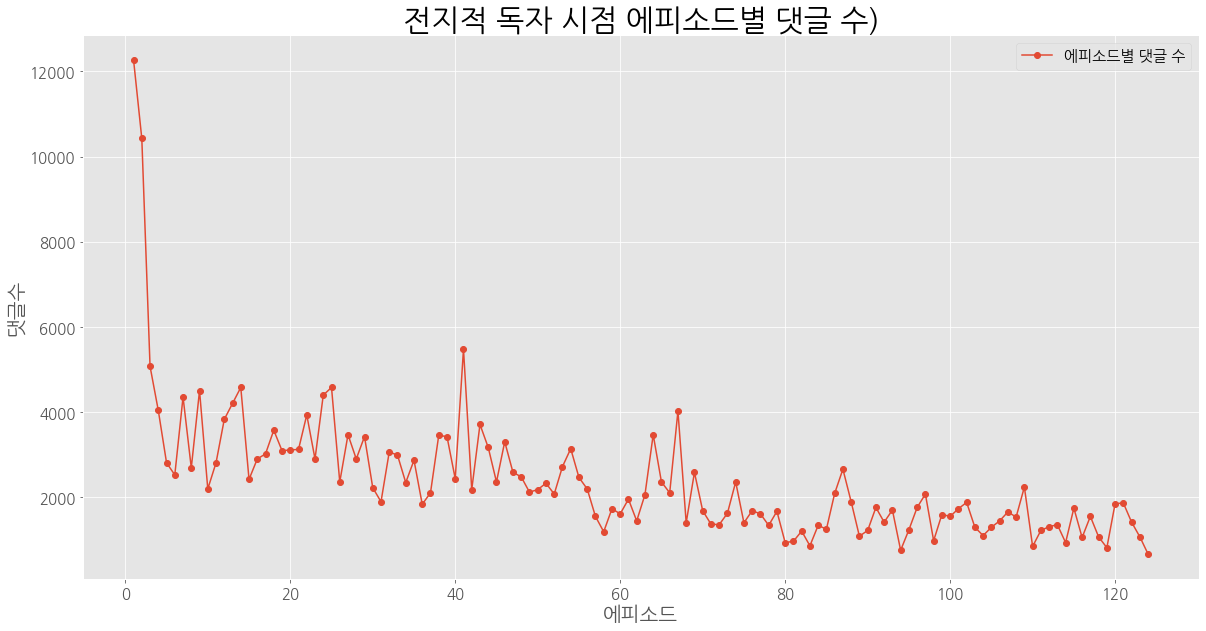

In [58]:
plt.rc('font', family='NanumGothic')
plt.style.use('ggplot')
plt.rc('font', size=15)

fig = plt.figure(figsize=(20,10))
ax = fig.subplots()
ax.plot(df.Episode, df.Num_reviews, label = '에피소드별 댓글 수', marker='o')
ax.legend(loc='upper right')

ax.set_ylabel('댓글수', fontsize = 20)
ax.set_xlabel('에피소드', fontsize = 20)
ax.set_title('전지적 독자 시점 에피소드별 댓글 수)', fontsize = 30)

In [72]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py
import plotly
import cufflinks as cf
import pandas as pd
import numpy as np

print(plt.style.available)

# plt.style.use('classic')

fig = df['Num_reviews'].iplot(kind='line',
                labels = "Episode", 
                values="Num_reviews", textinfo="percent+label",
                title= '전지적 독자 시점 에피소드별 댓글 수', hole = 0.5, asFigure=True,
                xTitle ='에피소드',
                yTitle ='댓글 수',
                color='green'              
              )
#     filename = './data/'+ word + '.html'   
#plotly.offline.plot(fig,filename=filename)
fig.show()

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [64]:
fig = df.iplot(kind='line',
                labels = "Episode", 
                values="Num_reviews", textinfo="percent+label",
                title= '전지적 독자 시점 에피소드별 댓글 수', hole = 0.5, asFigure=True,
                xTitle ='에피소드',
                yTitle ='댓글 수',
              )
#     filename = './data/'+ word + '.html'   
#plotly.offline.plot(fig,filename=filename)
fig.show()